In [1]:
import numpy as np
import h5py
from tqdm import tqdm
import random
import pandas as pd
import itertools as it
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

from utils import global_monotonicity_violation
from meta_feature import dataset_ids_CC18, anchor_list_denser, learner_zoo_abbreviation, learner_zoo

In [2]:
file_paths = Path.cwd() / '../dataset/LCDB11_ER_CC18_compress.hdf5'
dataset_CC18 = h5py.File(file_paths , 'r')['error rate'][...] 
dataset_nofs, dataset_minmaxfs, dataset_standardfs = dataset_CC18[..., 0, 0], dataset_CC18[..., 1, 0], dataset_CC18[..., 2, 0]

In [3]:
mono_matrix_y_nofs, mono_matrix_x_nofs = global_monotonicity_violation(dataset_nofs, flat_filter = False, bonferroni = True)
mono_matrix_y_minmaxfs, mono_matrix_x_minmaxfs = global_monotonicity_violation(dataset_minmaxfs, flat_filter = False, bonferroni = True)
mono_matrix_y_standardfs, mono_matrix_x_standardfs = global_monotonicity_violation(dataset_standardfs, flat_filter = False, bonferroni = True)


100%|██████████| 72/72 [00:02<00:00, 26.85it/s]


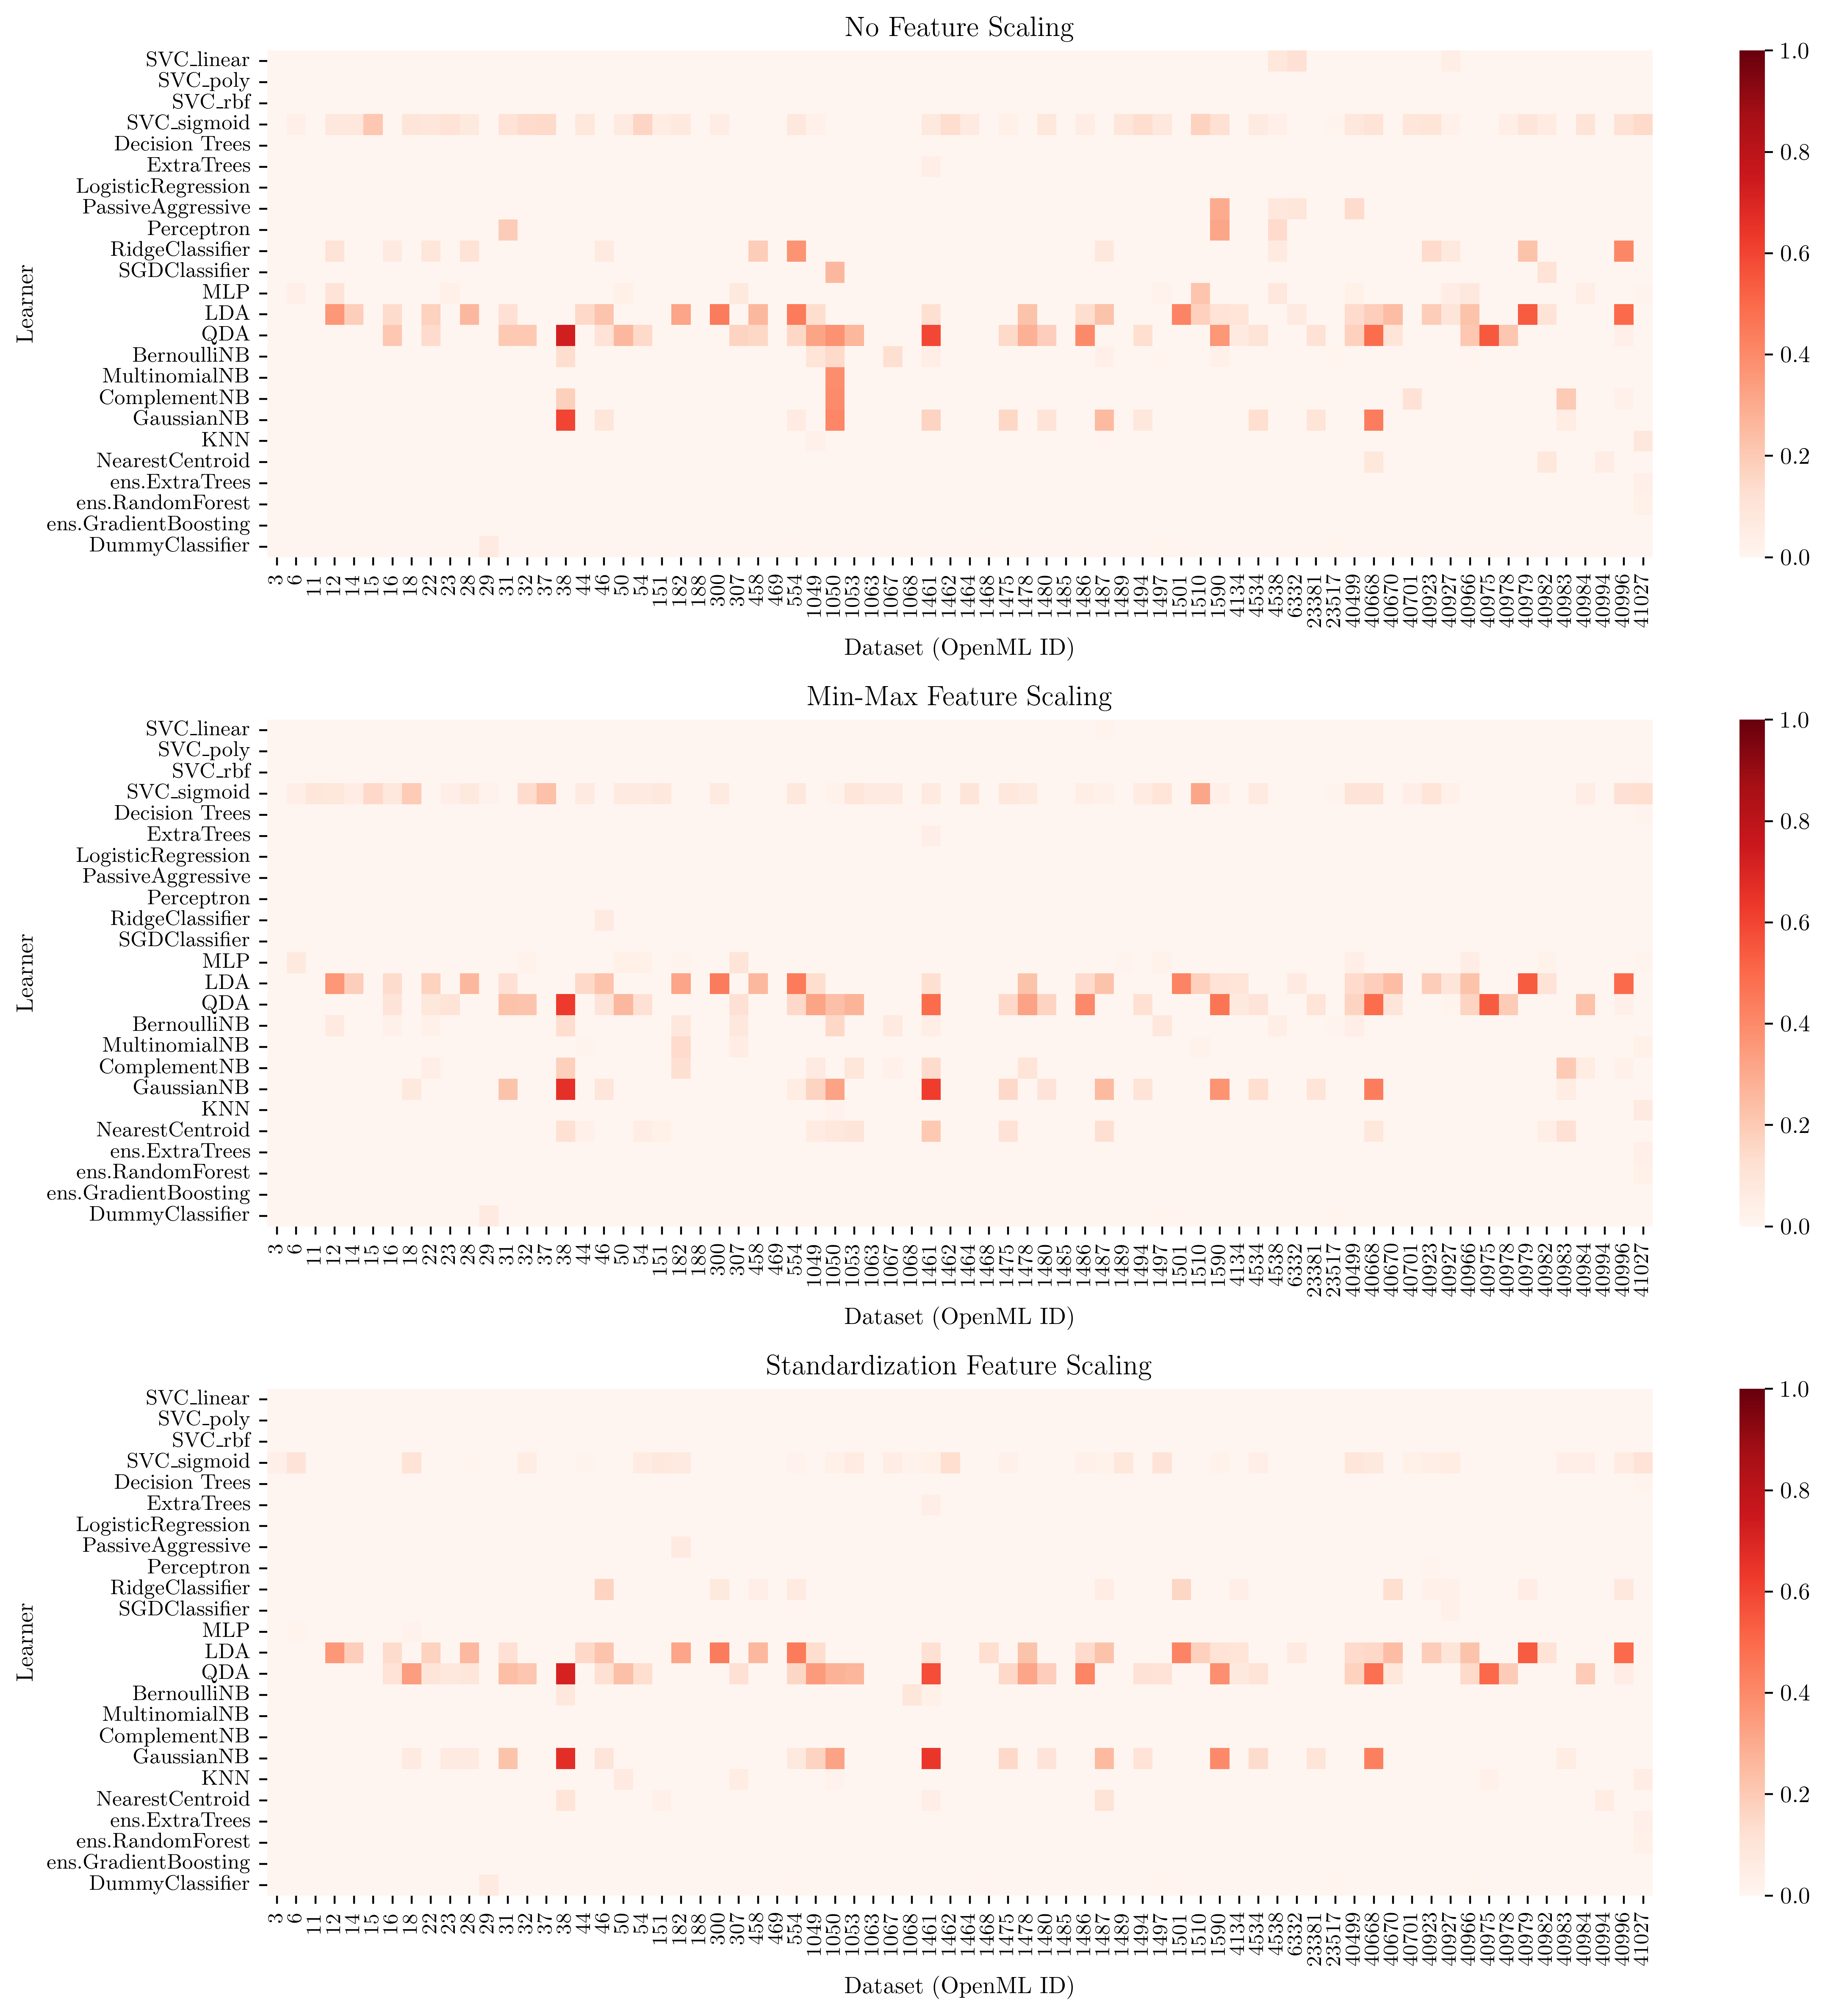

In [4]:
conv_matrices = [mono_matrix_y_nofs, mono_matrix_y_minmaxfs, mono_matrix_y_standardfs]
titles = ['No Feature Scaling', 'Min-Max Feature Scaling', 'Standardization Feature Scaling']

fig, axes = plt.subplots(3, 1, figsize=(12, 12), dpi=400) 

for ax, matrix, title in zip(axes, conv_matrices, titles):
    sns.heatmap(matrix, ax=ax, cmap="Reds", annot=False, cbar=True, vmin=0, vmax=1)
    ax.set_title(title)
    ax.set_yticks([y + 0.5 for y in range(len(learner_zoo))])
    ax.set_yticklabels(learner_zoo, rotation=0, fontsize=9)
    ax.set_xticks([x + 0.5 for x in range(len(dataset_ids_CC18))])
    ax.set_xticklabels(dataset_ids_CC18, rotation=90, fontsize=9)
    ax.set_xlabel('Dataset (OpenML ID)')
    ax.set_ylabel('Learner')

plt.tight_layout()
plt.show()


compare learner's mono 
which is bad 

In [5]:
percentages_nofs = (np.sum(mono_matrix_y_nofs > 0, axis=1) / mono_matrix_y_nofs.shape[1]) * 100
percentages_minmaxfs = (np.sum(mono_matrix_y_minmaxfs > 0, axis=1) / mono_matrix_y_minmaxfs.shape[1]) * 100
percentages_standardfs = (np.sum(mono_matrix_y_standardfs > 0, axis=1) / mono_matrix_y_standardfs.shape[1]) * 100


# filter some learner
exclude_indices = [13, 23]      # list(range(14, 18))  no Naive Bayes  13 QDA  23 DUMMY
learner_zoo_filtered = [learner for i, learner in enumerate(learner_zoo_abbreviation) if i not in exclude_indices]
percentages_nofs = [val for i, val in enumerate(percentages_nofs) if i not in exclude_indices]
percentages_minmaxfs = [val for i, val in enumerate(percentages_minmaxfs) if i not in exclude_indices]
percentages_standardfs = [val for i, val in enumerate(percentages_standardfs) if i not in exclude_indices]

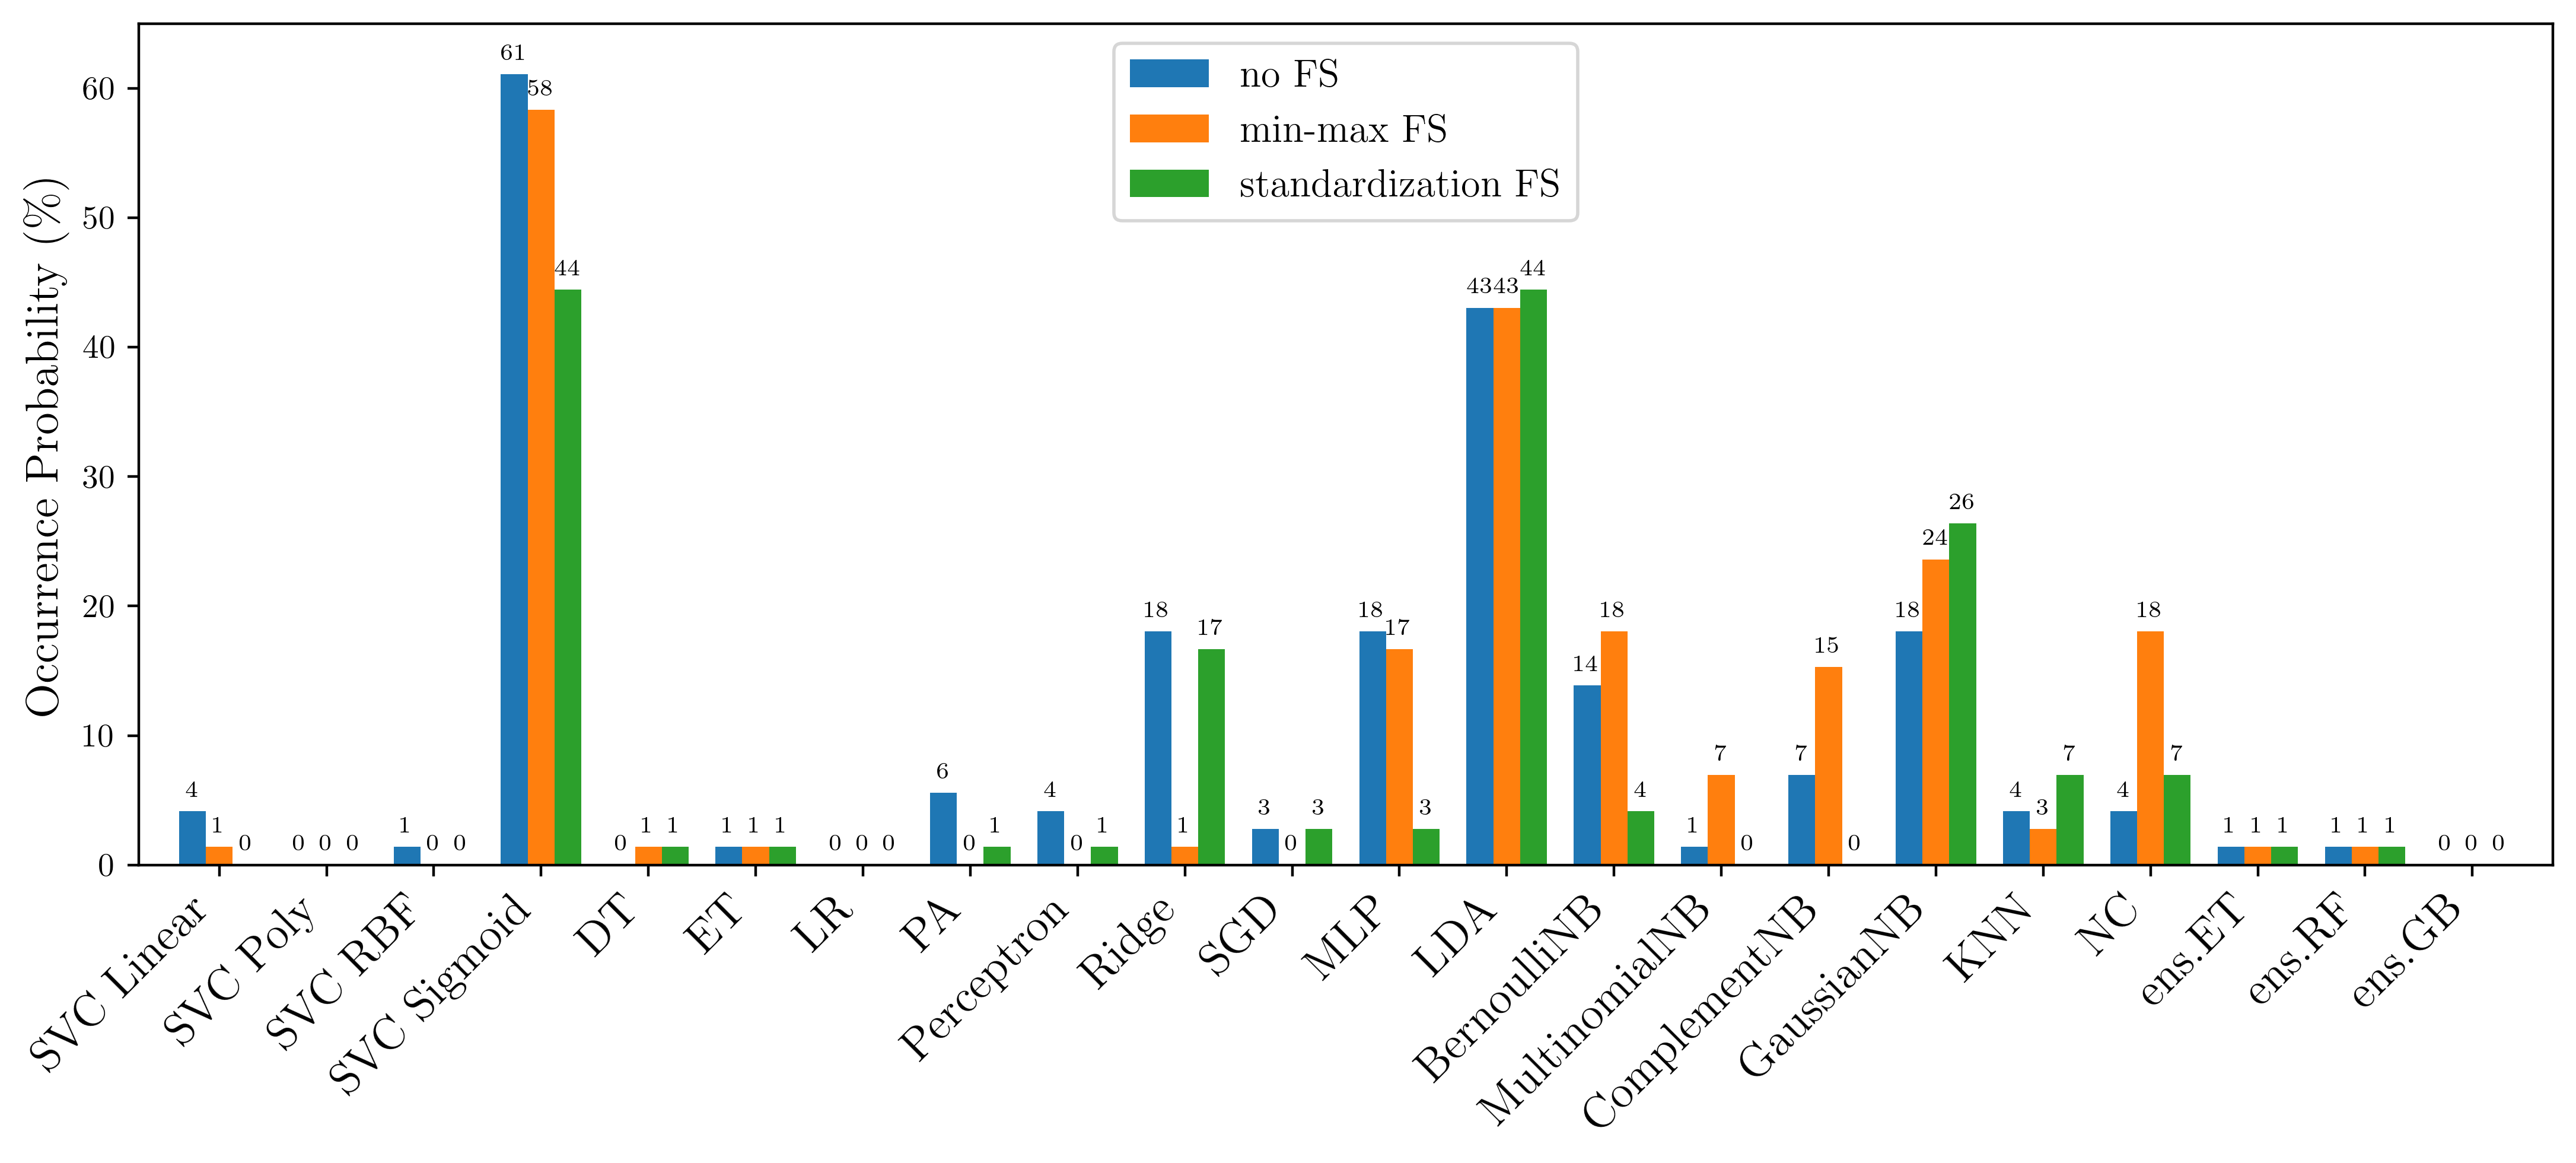

In [6]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=400)

width = 0.25
x = np.arange(len(learner_zoo_filtered))  

bar1 = ax.bar(x - width,    percentages_nofs,       width, label='no FS')
bar2 = ax.bar(x ,           percentages_minmaxfs,   width, label='min-max FS')
bar3 = ax.bar(x + width,    percentages_standardfs, width, label='standardization FS')

ax.set_ylabel(r'Occurrence Probability (\%)', fontsize = 14)
ax.set_ylim(0,65)
ax.set_xticks(x)
ax.set_xlim(x[0] - 3 * width, x[-1] + 3 * width)    # set tighter x-axis limits
ax.set_xticklabels(learner_zoo_filtered, rotation=45, ha='right', fontsize = 14)  
ax.legend(loc = 'upper center',fontsize = 12)



# percentage
def autolabel(bars):
    for rect in bars:
        height = rect.get_height()
        # if height > 0:  # only annotate bars with a height greater than 0
        ax.annotate(f'{height:.0f}',    # integer
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom', 
                    fontsize = 7)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
plt.show()


### all results

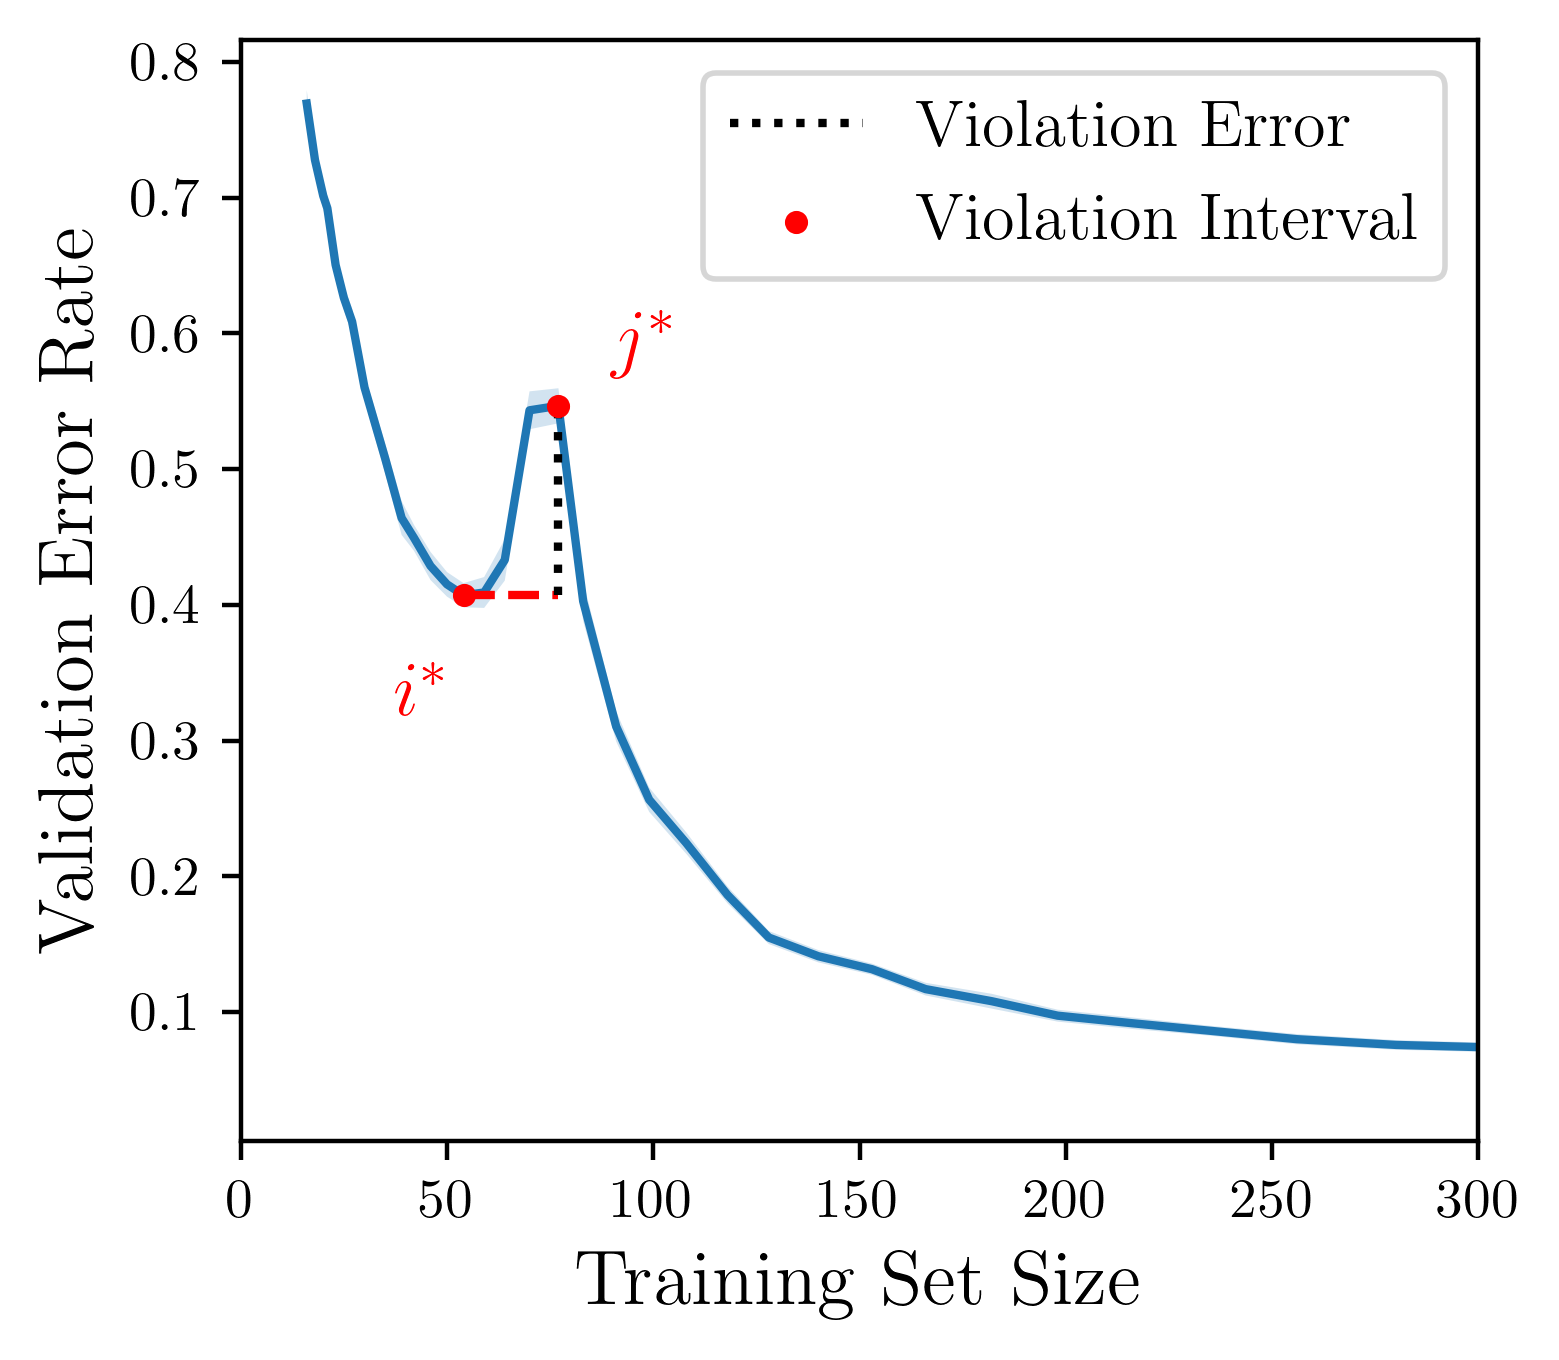

In [7]:
LEARNER, DATASET = 12, 6

lc_clean = dataset_nofs[DATASET, LEARNER, :, :, :, 1]
mean_clean = np.nanmean(lc_clean[:, :, :], axis=(0, 1))
se_clean = np.nanstd(lc_clean[:, :, :], axis=(0, 1), ddof=1) / np.sqrt(np.sum(~np.isnan(lc_clean[:, :, :]), axis=(0, 1)))

plt.figure(figsize=(4, 3.5), dpi=400)
plt.plot(anchor_list_denser, mean_clean)#, label="LCDB 1.1 noFS")
plt.fill_between(anchor_list_denser, mean_clean - se_clean, mean_clean + se_clean, alpha=0.2)

pair_indices = [(i, j) for i in range(len(mean_clean) - 1) for j in range(i + 1, len(mean_clean))]

max_difference = 0 
i_index, j_index = None, None
for (i, j) in pair_indices:
    diff = mean_clean[j] - mean_clean[i]
    if diff > max_difference:
        max_difference = diff
        i_index, j_index = i, j

if i_index is not None and j_index is not None:
    x1, x2 = anchor_list_denser[i_index], anchor_list_denser[j_index]
    y1, y2 = mean_clean[i_index], mean_clean[j_index]

    # h* and j* 
    plt.plot([x1, x2], [y1, y1], 'r--', linewidth=1.5, zorder=4)
    # violation error
    plt.vlines(x2, ymin=y1, ymax=y2, colors='black', linestyles='dotted', linewidth=1.5, zorder=4, label = 'Violation Error')

    plt.scatter([x1, x2], [y1, y2], color='red', s=10, zorder=5, label = 'Violation Interval')  
    
    plt.text(x1-10, y1 - 0.1, '$i^*$', fontsize=14, ha='center', va='bottom', color='red')  
    plt.text(x2+20, y2 + 0.02, '$j^*$', fontsize=14, ha='center', va='bottom', color='red')

plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Validation Error Rate', fontsize=14)
plt.xlim(0,300)
# plt.xscale('log')
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('1.png')
plt.show()


## dipping

In [8]:
mono_matrix_y_nofs, mono_matrix_x_nofs = global_monotonicity_violation(dataset_nofs, dipping=True)
mono_matrix_y_minmaxfs, mono_matrix_x_minmaxfs = global_monotonicity_violation(dataset_minmaxfs, dipping=True)
mono_matrix_y_standardfs, mono_matrix_x_standardfs = global_monotonicity_violation(dataset_standardfs, dipping=True)

100%|██████████| 72/72 [00:00<00:00, 76.09it/s]


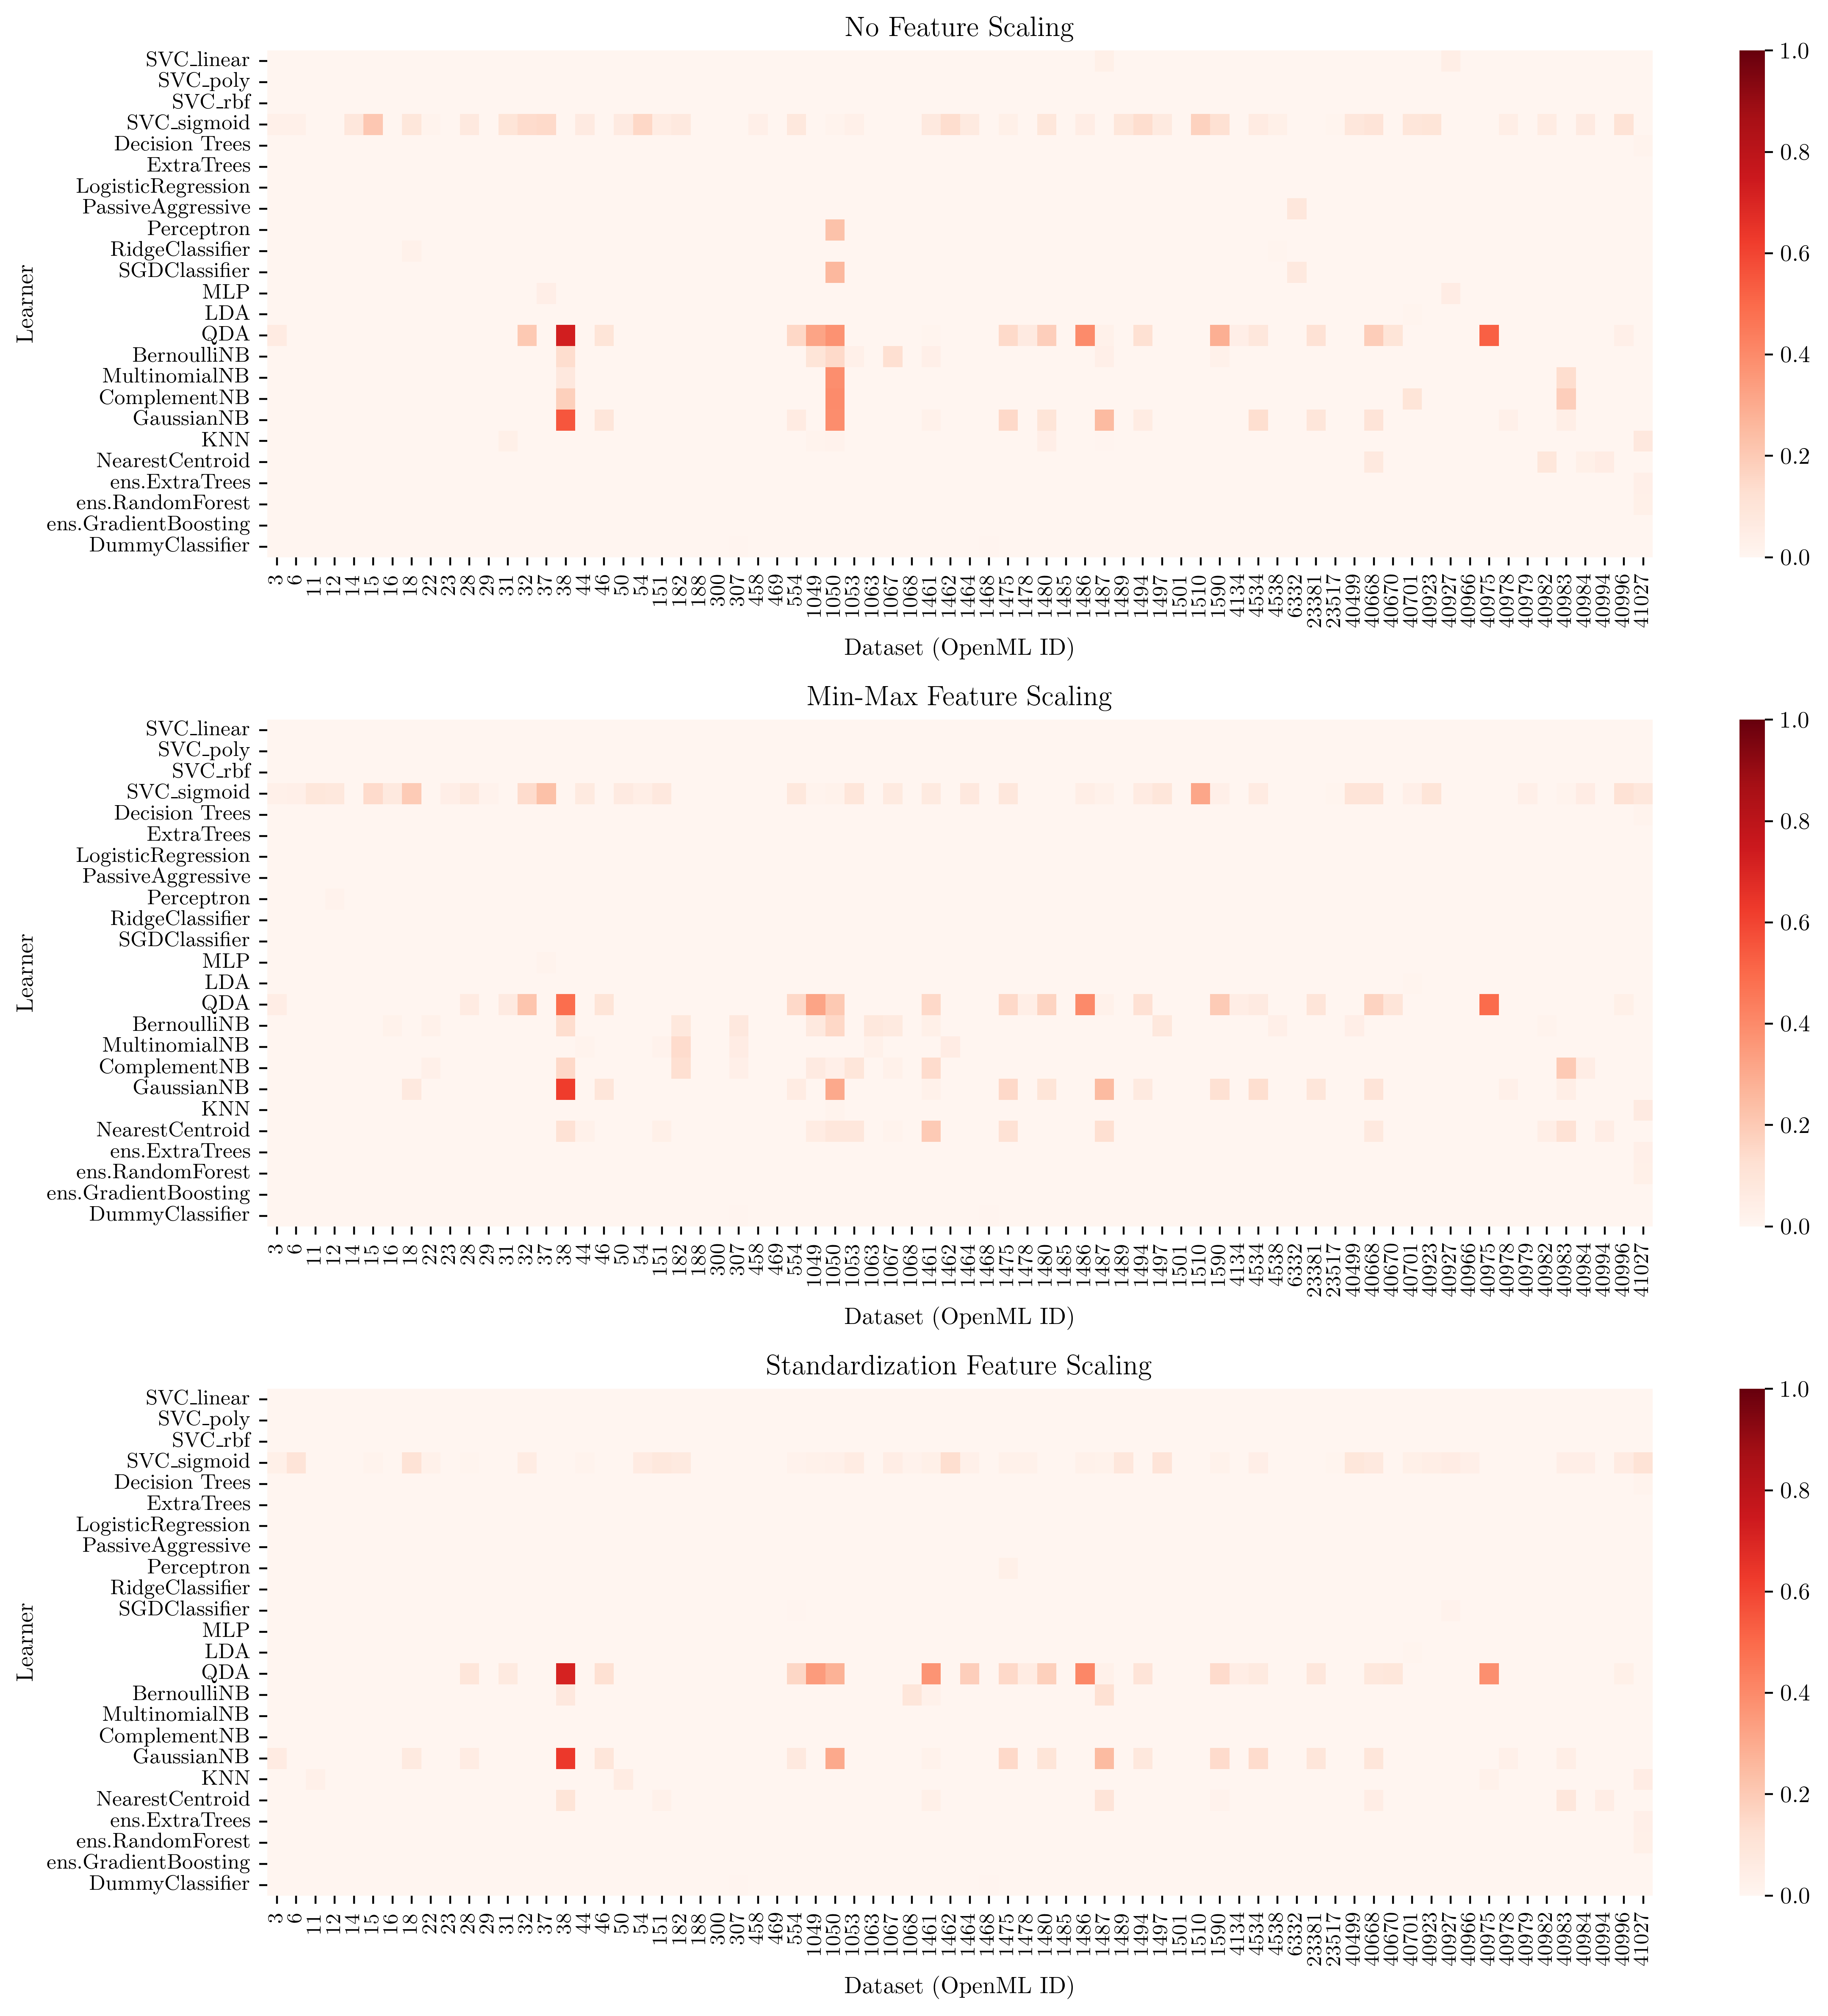

In [9]:
conv_matrices = [mono_matrix_y_nofs, mono_matrix_y_minmaxfs, mono_matrix_y_standardfs]
titles = ['No Feature Scaling', 'Min-Max Feature Scaling', 'Standardization Feature Scaling']

fig, axes = plt.subplots(3, 1, figsize=(12, 12), dpi=400) 

for ax, matrix, title in zip(axes, conv_matrices, titles):
    sns.heatmap(matrix, ax=ax, cmap="Reds", annot=False, cbar=True, vmin=0, vmax=1)
    ax.set_title(title)
    ax.set_yticks([y + 0.5 for y in range(len(learner_zoo))])
    ax.set_yticklabels(learner_zoo, rotation=0, fontsize=9)
    ax.set_xticks([x + 0.5 for x in range(len(dataset_ids_CC18))])
    ax.set_xticklabels(dataset_ids_CC18, rotation=90, fontsize=9)
    ax.set_xlabel('Dataset (OpenML ID)')
    ax.set_ylabel('Learner')

plt.tight_layout()
plt.show()


In [10]:
percentages_nofs = (np.sum(mono_matrix_y_nofs > 0, axis=1) / mono_matrix_y_nofs.shape[1]) * 100
percentages_minmaxfs = (np.sum(mono_matrix_y_minmaxfs > 0, axis=1) / mono_matrix_y_minmaxfs.shape[1]) * 100
percentages_standardfs = (np.sum(mono_matrix_y_standardfs > 0, axis=1) / mono_matrix_y_standardfs.shape[1]) * 100


# filter some learner
exclude_indices = [13, 23]      # list(range(14, 18))  no Naive Bayes  13 QDA  23 DUMMY
learner_zoo_filtered = [learner for i, learner in enumerate(learner_zoo_abbreviation) if i not in exclude_indices]
percentages_nofs = [val for i, val in enumerate(percentages_nofs) if i not in exclude_indices]
percentages_minmaxfs = [val for i, val in enumerate(percentages_minmaxfs) if i not in exclude_indices]
percentages_standardfs = [val for i, val in enumerate(percentages_standardfs) if i not in exclude_indices]

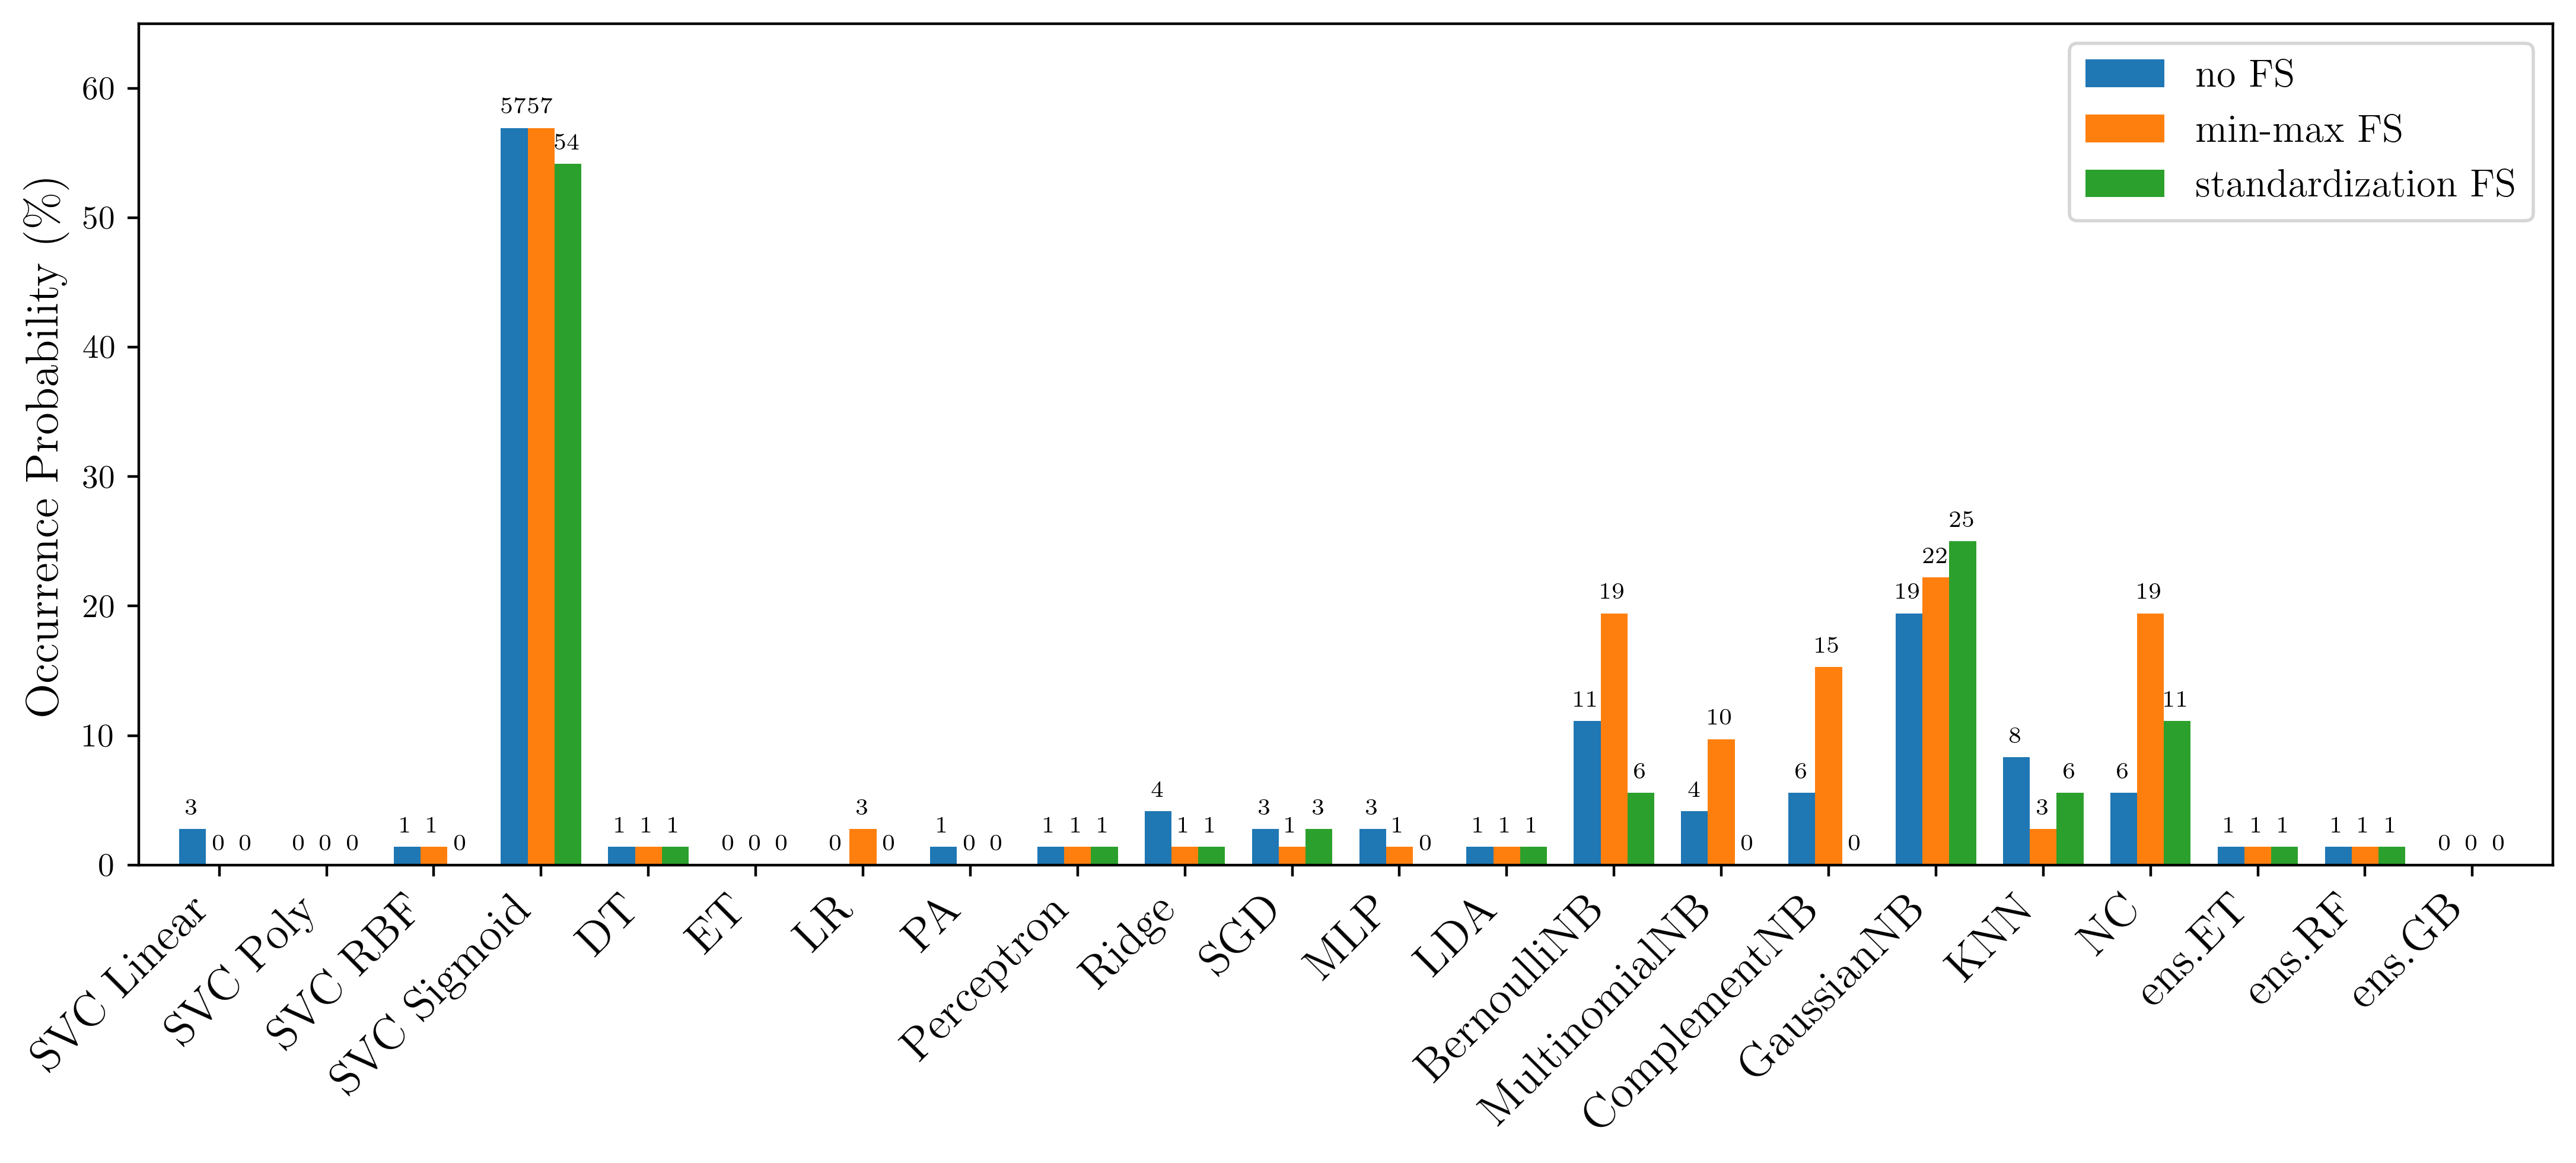

In [11]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=400)

width = 0.25
x = np.arange(len(learner_zoo_filtered))  

bar1 = ax.bar(x - width,    percentages_nofs,       width, label='no FS')
bar2 = ax.bar(x ,           percentages_minmaxfs,   width, label='min-max FS')
bar3 = ax.bar(x + width,    percentages_standardfs, width, label='standardization FS')

ax.set_ylabel(r'Occurrence Probability (\%)', fontsize = 14)
ax.set_ylim(0,65)
ax.set_xticks(x)
ax.set_xlim(x[0] - 3 * width, x[-1] + 3 * width)    # set tighter x-axis limits
ax.set_xticklabels(learner_zoo_filtered, rotation=45, ha='right', fontsize = 14)  
ax.legend(fontsize = 12)

# percentage
def autolabel(bars):
    for rect in bars:
        height = rect.get_height()
        # if height > 0:  # only annotate bars with a height greater than 0
        ax.annotate(f'{height:.0f}',    # integer
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom', 
                    fontsize = 7)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
plt.show()
